In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install prophet
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import optuna

In [5]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/VNP.csv')
# Chuyển đổi cột thời gian thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Tạo DataFrame dữ liệu đầu vào
df = pd.DataFrame({'ds': data['Date'], 'y': data['Price']})
df

,ds,y
0,2017-12-01,5100
1,2017-12-04,5800
2,2017-12-05,5700
3,2017-12-06,5800
4,2017-12-07,6300
...,...,...
1225,2023-06-05,14700
1226,2023-06-06,14900
1227,2023-06-07,14800
1228,2023-06-08,14400


In [6]:
# Chia tập dữ liệu thành train-test-validate theo tỉ lệ
n = len(df)
n_train = int(n * 0.6)
n_test = int(n * 0.3)
n_validate = n - n_train - n_test

train_data = df[:n_train]
test_data = df[n_train:n_train + n_test]
validate_data = df[n_train + n_test:]

In [7]:
# Hàm mục tiêu để tối ưu hóa
def objective(trial):
    # Xác định không gian tìm kiếm cho siêu tham số
    params = {
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 1.0),
        'holidays_prior_scale': trial.suggest_loguniform('holidays_prior_scale', 0.01, 10.0),
    }

    # Xây dựng mô hình BSTS với siêu tham số hiện tại
    model = Prophet(**params)
    model.fit(train_data)

    # Dự đoán trên tập test
    forecast = model.predict(test_data)

    # Tính toán độ đo RMSE để đánh giá mô hình
    rmse = mean_squared_error(test_data['y'], forecast['yhat'], squared=False)

    return rmse

In [8]:
# Tìm giá trị tối ưu cho siêu tham số
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=350)

# Lấy giá trị tối ưu cho siêu tham số
best_params = study.best_params

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] done processing
[I 2023-06-18 16:04:03,661] Trial 55 finished with value: 7916.174086575737 and parameters: {'changepoint_prior_scale': 0.013462820148306492, 'seasonality_prior_scale': 0.5232317120513608, 'holidays_prior_scale': 0.018748016731754066}. Best is trial 42 with value: 7812.514904187693.
<ipython-input-7-bb80d6b1eb20>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
<ipython-input-7-bb80d6b1eb20>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'seasonality_prior_scale': trial.suggest_logunifor

In [9]:
# Xây dựng mô hình BSTS với siêu tham số tốt nhất
best_model = Prophet(**best_params)
best_model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr7tfw66j/3jb52rlh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr7tfw66j/1il7oh9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79946', 'data', 'file=/tmp/tmpr7tfw66j/3jb52rlh.json', 'init=/tmp/tmpr7tfw66j/1il7oh9r.json', 'output', 'file=/tmp/tmpr7tfw66j/prophet_modelvygvikol/prophet_model-20230618160702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:07:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
print("Siêu tham số tối ưu:", best_params)

Siêu tham số tối ưu: {'changepoint_prior_scale': 0.010185472512614025, 'seasonality_prior_scale': 0.8643743458414328, 'holidays_prior_scale': 0.013165616983055071}


In [11]:
# Dự đoán trên tập test và validate
test_forecast = best_model.predict(test_data)
validate_forecast = best_model.predict(validate_data)

In [12]:
# Dự đoán 30 ngày tiếp theo
future_dates = pd.date_range(start=df['ds'].max(), periods=30, freq='D')
future_data = pd.DataFrame({'ds': future_dates})

future_forecast = best_model.predict(future_data)

In [13]:
# In kết quả dự đoán
future_forecast['yhat']

0     29199.820529
1     28643.269219
2     28664.199184
3     29201.911699
4     29243.778659
5     29302.913529
6     29313.058065
7     29338.557409
8     28778.929370
9     28798.403520
10    29336.206367
11    29379.599909
12    29441.555051
13    29455.641473
14    29486.006489
15    28931.948648
16    28957.461632
17    29501.524614
18    29551.146290
19    29619.043981
20    29638.539243
21    29673.542454
22    29123.131976
23    29151.103368
24    29696.264662
25    29745.484849
26    29811.376826
27    29827.196191
28    29856.828246
29    29299.368760
Name: yhat, dtype: float64

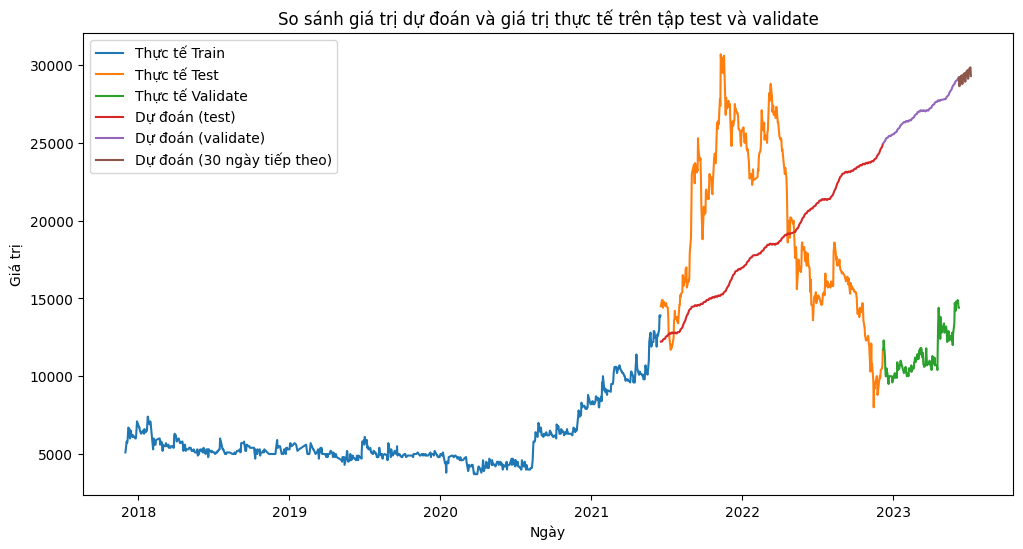

In [14]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Thực tế Train')
plt.plot(test_data['ds'], test_data['y'], label='Thực tế Test')
plt.plot(validate_data['ds'], validate_data['y'], label='Thực tế Validate')
plt.plot(test_data['ds'], test_forecast['yhat'], label='Dự đoán (test)')
plt.plot(validate_data['ds'], validate_forecast['yhat'], label='Dự đoán (validate)')
plt.plot(future_dates, future_forecast['yhat'], label='Dự đoán (30 ngày tiếp theo)')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập test và validate')
plt.legend()
plt.show()

In [15]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho test data
rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast['yhat']))
mape = mean_absolute_percentage_error(test_data['y'], test_forecast['yhat'])*100
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
r2 = r2_score(test_data['y'], test_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 7812.514904187693
MAPE: 38.879309767251534
MSE: 61035389.128154844
MAE: 6850.813185313537
R2: -1.007505051078228


In [16]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho validate data
rmse = np.sqrt(mean_squared_error(validate_data['y'], validate_forecast['yhat']))
mape = mean_absolute_percentage_error(validate_data['y'], validate_forecast['yhat'])*100
mse = mean_squared_error(validate_data['y'], validate_forecast['yhat'])
mae = mean_absolute_error(validate_data['y'], validate_forecast['yhat'])
r2 = r2_score(validate_data['y'], validate_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 15605.348041427238
MAPE: 138.8392570887408
MSE: 243526887.49407694
MAE: 15584.809537620278
R2: -128.81837852734017
